<a href="https://colab.research.google.com/drive/1bNXo-NmB2RjZLdYvaVoT-Ni_7U1V0Ls9?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este análisis buscamos predecir el Billing Amount de los pacientes utilizando un modelo de regresión.
Para ello, es importante seleccionar adecuadamente las variables que realmente aportan información al modelo y eliminar aquellas que solo generan ruido.

### Importando paquetes y el conjunto de datos

In [8]:
pip install numpy pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [204]:
#Hecho en clases
#df = pd.read_csv("https://github.com/ulewis/Ejemplos/raw/main/Datos/USA_Housing.csv")

#Lo que usameros 
df = pd.read_csv("https://github.com/ulewis/Ejemplos/raw/main/Datos/healthcare_dataset.csv")
df.head()  # vemos los 5 primeros datos del dataframe

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Tiffany Ramirez,81,Female,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive
1,Ruben Burns,35,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal
2,Chad Byrd,61,Male,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal
3,Antonio Frederick,49,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal
4,Mrs. Brandy Flowers,51,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal


### Consultar información básica sobre el conjunto de datos

**El método 'info()'los tipos y números de datos**

In [163]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10000 non-null  object 
 1   Age                 10000 non-null  int64  
 2   Gender              10000 non-null  object 
 3   Blood Type          10000 non-null  object 
 4   Medical Condition   10000 non-null  object 
 5   Date of Admission   10000 non-null  object 
 6   Doctor              10000 non-null  object 
 7   Hospital            10000 non-null  object 
 8   Insurance Provider  10000 non-null  object 
 9   Billing Amount      10000 non-null  float64
 10  Room Number         10000 non-null  int64  
 11  Admission Type      10000 non-null  object 
 12  Discharge Date      10000 non-null  object 
 13  Medication          10000 non-null  object 
 14  Test Results        10000 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 1.1+

Nuestra data tiene varios object, siendo que no seria necesario usar la mayoria como nombre,hospital o doctor, vemos cuales serian esenciales y modificar.

In [164]:
# Solo columnas categóricas (object)
categorical_cols = df.select_dtypes(include=['object']).columns

# Contar valores únicos en cada columna
unique_counts = df[categorical_cols].nunique().sort_values(ascending=False)

print(unique_counts)


Doctor                9416
Name                  9378
Hospital              8639
Discharge Date        1834
Date of Admission     1815
Blood Type               8
Medical Condition        6
Insurance Provider       5
Medication               5
Admission Type           3
Test Results             3
Gender                   2
dtype: int64


Para tener mejor detalle restamos el dia de admision del paciente con su alta para saber cuantos dias se quedo, considerando que eso tambien considera a nuestra opción.

In [213]:
date = pd.to_datetime(df["Date of Admission"])
discharga = pd.to_datetime(df["Discharge Date"])

df["duracion"] = (discharga - date).dt.days


In [214]:
# Sabemos que valores de la columna gender son "Male" y "Female"
#Así que usariamos binary como solo tenemos 2 opciones.
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})


In [ ]:
#Tambien usaremos One-Hot para las demas categoria que vamos a utilizar.
one_hot_cols = ["Medical Condition", "Insurance Provider",
                "Medication", "Admission Type", "Test Results"]

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=False)
#df = df.astype({col: int for col in df.select_dtypes('bool').columns})
df

,Name,Age,Gender,Blood Type,Date of Admission,Doctor,Hospital,Billing Amount,Room Number,Discharge Date,...,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin,Admission Type_Elective,Admission Type_Emergency,Admission Type_Urgent,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
0,Tiffany Ramirez,81,Female,O-,2022-11-17,Patrick Parker,Wallace-Hamilton,37490.983364,146,2022-12-01,...,False,False,False,False,True,False,False,False,True,False
1,Ruben Burns,35,Male,O+,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",47304.064845,404,2023-06-15,...,False,True,False,False,False,True,False,False,False,True
2,Chad Byrd,61,Male,B-,2019-01-09,Paul Baker,Walton LLC,36874.896997,292,2019-02-08,...,False,True,False,False,False,True,False,False,False,True
3,Antonio Frederick,49,Male,B-,2020-05-02,Brian Chandler,Garcia Ltd,23303.322092,480,2020-05-03,...,False,False,False,True,False,False,True,True,False,False
4,Mrs. Brandy Flowers,51,Male,O-,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",18086.344184,477,2021-08-02,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,James Hood,83,Male,A+,2022-07-29,Samuel Moody,"Wood, Martin and Simmons",39606.840083,110,2022-08-02,...,True,False,False,False,True,False,False,True,False,False
9996,Stephanie Evans,47,Female,AB+,2022-01-06,Christopher Yates,Nash-Krueger,5995.717488,244,2022-01-29,...,True,False,False,False,False,True,False,False,False,True
9997,Christopher Martinez,54,Male,B-,2022-07-01,Robert Nicholson,Larson and Sons,49559.202905,312,2022-07-15,...,True,False,False,False,True,False,False,False,False,True
9998,Amanda Duke,84,Male,A+,2020-02-06,Jamie Lewis,Wilson-Lyons,25236.344761,420,2020-02-26,...,False,False,False,True,False,False,True,False,False,True


In [168]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Name                                 10000 non-null  object 
 1   Age                                  10000 non-null  int64  
 2   Gender                               10000 non-null  int64  
 3   Blood Type                           10000 non-null  object 
 4   Date of Admission                    10000 non-null  object 
 5   Doctor                               10000 non-null  object 
 6   Hospital                             10000 non-null  object 
 7   Billing Amount                       10000 non-null  float64
 8   Room Number                          10000 non-null  int64  
 9   Discharge Date                       10000 non-null  object 
 10  duracion                             10000 non-null  int64  
 11  Medical Condition_Arthritis  

**El método 'describe()' obtiene un resumen de estadísticas de las características del conjunto de datos**

In [169]:
df.describe()


,Age,Gender,Billing Amount,Room Number,duracion,Medical Condition_Arthritis,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,...,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin,Admission Type_Elective,Admission Type_Emergency,Admission Type_Urgent,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,51.452200,0.507500,25516.806778,300.082000,15.561800,0.165000,0.170800,0.170300,0.162300,0.168800,...,0.197600,0.201500,0.196200,0.207900,0.324200,0.336700,0.339100,0.345600,0.327700,0.32670
std,19.588974,0.499969,14067.292709,115.806027,8.612038,0.371199,0.376353,0.375915,0.368744,0.374594,...,0.398209,0.401141,0.397141,0.405825,0.468099,0.472605,0.473428,0.475587,0.469398,0.46903
min,18.000000,0.000000,1000.180837,101.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,35.000000,0.000000,13506.523967,199.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,52.000000,1.000000,25258.112566,299.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,68.000000,1.000000,37733.913727,400.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
max,85.000000,1.000000,49995.902283,500.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


**El método 'columns' obtiene los nombres de las columnas (características)**

In [174]:
df.columns


Index(['Name', 'Age', 'Gender', 'Blood Type', 'Date of Admission', 'Doctor',
       'Hospital', 'Billing Amount', 'Room Number', 'Discharge Date',
       'duracion', 'Medical Condition_Arthritis', 'Medical Condition_Asthma',
       'Medical Condition_Cancer', 'Medical Condition_Diabetes',
       'Medical Condition_Hypertension', 'Medical Condition_Obesity',
       'Insurance Provider_Aetna', 'Insurance Provider_Blue Cross',
       'Insurance Provider_Cigna', 'Insurance Provider_Medicare',
       'Insurance Provider_UnitedHealthcare', 'Medication_Aspirin',
       'Medication_Ibuprofen', 'Medication_Lipitor', 'Medication_Paracetamol',
       'Medication_Penicillin', 'Admission Type_Elective',
       'Admission Type_Emergency', 'Admission Type_Urgent',
       'Test Results_Abnormal', 'Test Results_Inconclusive',
       'Test Results_Normal'],
      dtype='object')

### Visualización básica del conjunto de datos

**Pairplots usando seaborn**

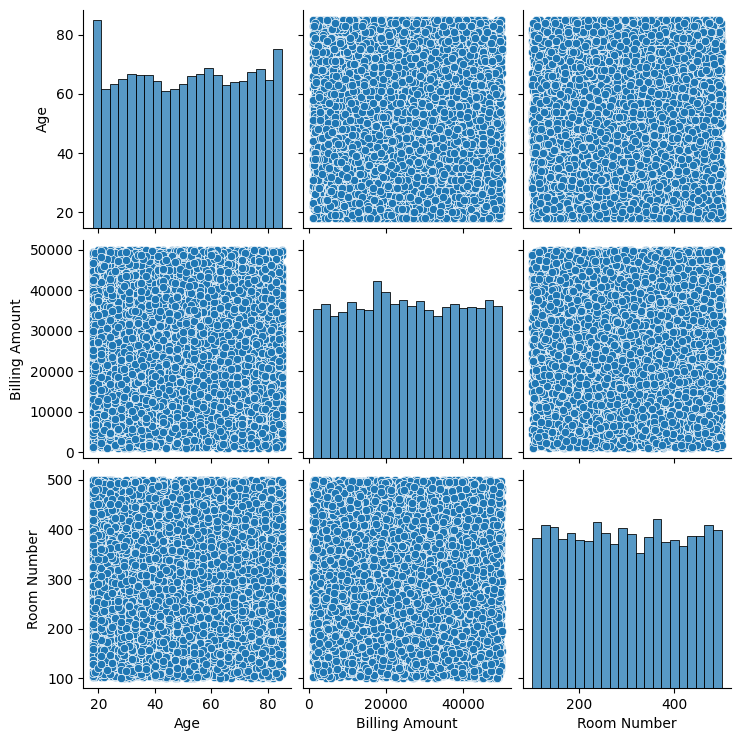

In [205]:
sns.pairplot(df)

**Distribución del precio (la cantidad prevista)**

<Axes: ylabel='Frequency'>

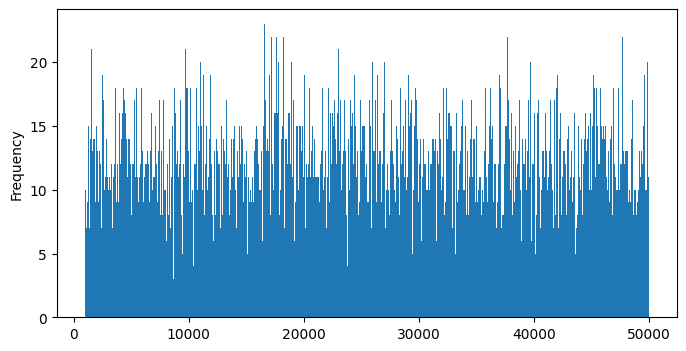

In [173]:
df['Billing Amount'].plot.hist(bins=800,figsize=(8,4))

**Matriz de correlación y heatmap**

In [215]:
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.corr()

,Age,Gender,Billing Amount,Room Number,duracion
Age,1.000000,0.008099,-0.009483,-0.005371,0.009111
Gender,0.008099,1.000000,-0.002340,-0.002864,0.006361
Billing Amount,-0.009483,-0.002340,1.000000,-0.006160,-0.013507
Room Number,-0.005371,-0.002864,-0.006160,1.000000,0.009610
duracion,0.009111,0.006361,-0.013507,0.009610,1.000000


<Axes: >

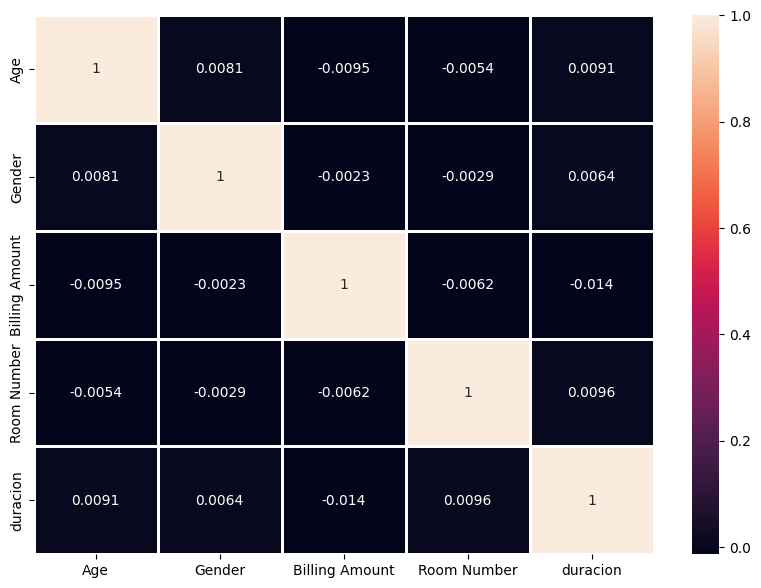

In [216]:
plt.figure(figsize=(10,7))
sns.heatmap(numeric_df.corr(),annot=True,linewidths=2)

### Conjuntos de características y variables

**Haga una lista de los nombres de las columnas del dataframe**

In [177]:
l_column = list(df.columns) # Haciendo una lista de las columnas
len_feature = len(l_column) # Longitud de la lista de vectores de columna
l_column

['Name',
 'Age',
 'Gender',
 'Blood Type',
 'Date of Admission',
 'Doctor',
 'Hospital',
 'Billing Amount',
 'Room Number',
 'Discharge Date',
 'duracion',
 'Medical Condition_Arthritis',
 'Medical Condition_Asthma',
 'Medical Condition_Cancer',
 'Medical Condition_Diabetes',
 'Medical Condition_Hypertension',
 'Medical Condition_Obesity',
 'Insurance Provider_Aetna',
 'Insurance Provider_Blue Cross',
 'Insurance Provider_Cigna',
 'Insurance Provider_Medicare',
 'Insurance Provider_UnitedHealthcare',
 'Medication_Aspirin',
 'Medication_Ibuprofen',
 'Medication_Lipitor',
 'Medication_Paracetamol',
 'Medication_Penicillin',
 'Admission Type_Elective',
 'Admission Type_Emergency',
 'Admission Type_Urgent',
 'Test Results_Abnormal',
 'Test Results_Inconclusive',
 'Test Results_Normal']

**Coloque todas las características numéricas en X y el precio en y, ignore la dirección, que es una cadena para la regresión lineal**

In [178]:
#X = df[l_column[0:len_feature-2]]
#y = df[l_column[len_feature-2]]
no_se_usa = ["Name", "Date of Admission", "Discharge Date", "Doctor", "Hospital", "Room Number","Blood Type", "Billing Amount"]
X= df.drop(columns=no_se_usa)
y=df["Billing Amount"]

In [179]:
print("Tamaño de Características:",X.shape)
print("Tamaño de Variable Objetivo:",y.shape)

Tamaño de Características: (10000, 25)
Tamaño de Variable Objetivo: (10000,)


In [180]:
X.head()

,Age,Gender,duracion,Medical Condition_Arthritis,Medical Condition_Asthma,Medical Condition_Cancer,Medical Condition_Diabetes,Medical Condition_Hypertension,Medical Condition_Obesity,Insurance Provider_Aetna,...,Medication_Ibuprofen,Medication_Lipitor,Medication_Paracetamol,Medication_Penicillin,Admission Type_Elective,Admission Type_Emergency,Admission Type_Urgent,Test Results_Abnormal,Test Results_Inconclusive,Test Results_Normal
0,81,1,14,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,35,0,14,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,61,0,30,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,49,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
4,51,0,24,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [181]:
y.head()

0    37490.983364
1    47304.064845
2    36874.896997
3    23303.322092
4    18086.344184
Name: Billing Amount, dtype: float64

### División de entrenamiento-prueba

In [59]:
pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   -------------------------------------- - 8.7/8.9 MB 77.0 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 29.0 MB/s  0:00:00
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
   --------------- ------------------------ 16.3/41.3 MB 78.8 MB/s eta 0:00:01
   -------------------------------- ------- 33.6/41.3 MB 78.9 MB/s eta 0:00:01
   ---------------------------------------  41.2/41.3 MB 77.0 MB/s eta 0:00:01
   ---------------------------------------  41.2/41.3 MB 77.0 MB/s eta 0:00:01
   ---------------------------------------  41.2/41.3 MB 77.0 MB/s eta 0:00:01
   ---------------------------------------  41.2/41.3 MB 77.0 MB/s eta 0:00:01
   ---------------------------------------  41.2/41.3 MB 77.0 MB/s eta 0:00:01
   ---------------------------------------  41.2/41.3 MB 77.0 MB/s eta 0:00:01
   ---------------------------------------  41.2/41.3 MB 77.0 MB/s eta 0:00:01

**Importamos la función train_test_split de scikit-learn**

In [182]:
from sklearn.model_selection import train_test_split

**Creamos los conjuntos de entrenamiento X y de prueba y en un comando usando una proporción de división y una semilla aleatoria**

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124)

**Verifique el tamaño y la forma de las divisiones de entrenamiento/prueba (debe estar en la proporción según el parámetro test_size anterior)**

In [184]:
print("Tamaño del conjunto de características del entrenamiento:",X_train.shape)
print("Tamaño del conjunto de características de prueba:",X_test.shape)
print("Tamaño de la variable objetivo del entrenamiento:",y_train.shape)
print("Tamaño de la variable objetivo de prueba:",y_test.shape)

Tamaño del conjunto de características del entrenamiento: (8000, 25)
Tamaño del conjunto de características de prueba: (2000, 25)
Tamaño de la variable objetivo del entrenamiento: (8000,)
Tamaño de la variable objetivo de prueba: (2000,)


### Ajuste y entrenamiento del modelo

**Importamos el estimador de modelo de regresión lineal de scikit-learn e lo instanciamos**

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [186]:
lm = LinearRegression() # Creando un objeto de Regresión Lineal 'lm'

**Ajustamos el modelo al propio objeto instanciado**

In [188]:
lm.fit(X_train,y_train) # Ajuste el modelo lineal en el objeto 'lm' en sí, es decir, no es necesario establecer esto en otra variable

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


**Verificamos la intercepción y los coeficientes y los colocamos en un DataFrame**

In [189]:
print("El término de intersección del modelo lineal:", lm.intercept_)

El término de intersección del modelo lineal: 26133.33541302681


In [190]:
print("Los coeficientes del modelo lineal:", lm.coef_)

Los coeficientes del modelo lineal: [  -7.55524135 -143.23890703  -11.76780596 -231.72265007 -338.97494919
    8.38600241  399.81854364  -17.73855447  180.23160768  195.36268467
  291.55502139  209.30198377 -485.28573265 -210.93395719  206.76635979
  184.83926025  509.51091569 -509.19029679 -391.92623894  338.39718071
 -677.21204553  338.81486482   16.26673401  284.94571192 -301.21244593]


In [192]:
#idict = {'Coefficients':lm.intercept_}
#idf = pd.DataFrame(data=idict,index=['Intercept'])
cdf = pd.DataFrame(data=lm.coef_, index=X_train.columns, columns=["Coefficients"])
#cdf=pd.concat([idf,cdf], axis=0)
cdf

,Coefficients
Age,-7.555241
Gender,-143.238907
duracion,-11.767806
Medical Condition_Arthritis,-231.722650
Medical Condition_Asthma,-338.974949
Medical Condition_Cancer,8.386002
Medical Condition_Diabetes,399.818544
Medical Condition_Hypertension,-17.738554
Medical Condition_Obesity,180.231608
Insurance Provider_Aetna,195.362685


### Cálculo de errores estándar y estadística t para los coeficientes

In [193]:
n=X_train.shape[0]
k=X_train.shape[1]
dfN = n-k
train_pred=lm.predict(X_train)
train_error = np.square(train_pred - y_train)
sum_error=np.sum(train_error)
se=[0] * len(X_train.columns) #cantidad de columnas que tenemos
for i in range(k):
    r = (sum_error/dfN)
    r = r/np.sum(np.square(X_train[list(X_train.columns)[i]]-X_train[list(X_train.columns)[i]].mean()))
    se[i]=np.sqrt(r)
cdf['Standard Error']=se
cdf['t-statistic']=cdf['Coefficients']/cdf['Standard Error']
cdf

,Coefficients,Standard Error,t-statistic
Age,-7.555241,7.967179,-0.948296
Gender,-143.238907,313.422529,-0.457015
duracion,-11.767806,18.193979,-0.646797
Medical Condition_Arthritis,-231.722650,423.993436,-0.546524
Medical Condition_Asthma,-338.974949,417.054853,-0.812783
Medical Condition_Cancer,8.386002,414.530197,0.020230
Medical Condition_Diabetes,399.818544,428.262877,0.933582
Medical Condition_Hypertension,-17.738554,420.274331,-0.042207
Medical Condition_Obesity,180.231608,419.397099,0.429740
Insurance Provider_Aetna,195.362685,391.396706,0.499142


In [194]:
print("Por lo tanto, las características organizadas en orden de importancia para predecir el precio de la vivienda\n",'-'*90,sep='')
l=list(cdf.sort_values('t-statistic',ascending=False).index)
print(' > \n'.join(l))

Por lo tanto, las características organizadas en orden de importancia para predecir el precio de la vivienda
------------------------------------------------------------------------------------------
Medication_Lipitor > 
Admission Type_Urgent > 
Admission Type_Elective > 
Medical Condition_Diabetes > 
Test Results_Inconclusive > 
Insurance Provider_Blue Cross > 
Insurance Provider_Cigna > 
Medication_Aspirin > 
Insurance Provider_Aetna > 
Medication_Ibuprofen > 
Medical Condition_Obesity > 
Test Results_Abnormal > 
Medical Condition_Cancer > 
Medical Condition_Hypertension > 
Gender > 
Insurance Provider_UnitedHealthcare > 
Medical Condition_Arthritis > 
duracion > 
Medical Condition_Asthma > 
Test Results_Normal > 
Age > 
Medication_Penicillin > 
Insurance Provider_Medicare > 
Medication_Paracetamol > 
Admission Type_Emergency


In [ ]:
l=list(cdf.index)
from matplotlib import gridspec
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2,3)
#f, ax = plt.subplots(nrows=1,ncols=len(l), sharey=True)
ax0 = plt.subplot(gs[0])
ax0.scatter(df[l[0]],df['Price'])
ax0.set_title(l[0]+" vs. Price", fontdict={'fontsize':20})

ax1 = plt.subplot(gs[1])
ax1.scatter(df[l[1]],df['Price'])
ax1.set_title(l[1]+" vs. Price",fontdict={'fontsize':20})

ax2 = plt.subplot(gs[2])
ax2.scatter(df[l[2]],df['Price'])
ax2.set_title(l[2]+" vs. Price",fontdict={'fontsize':20})

ax3 = plt.subplot(gs[3])
ax3.scatter(df[l[3]],df['Price'])
ax3.set_title(l[3]+" vs. Price",fontdict={'fontsize':20})

ax4 = plt.subplot(gs[4])
ax4.scatter(df[l[4]],df['Price'])
ax4.set_title(l[4]+" vs. Price",fontdict={'fontsize':20})

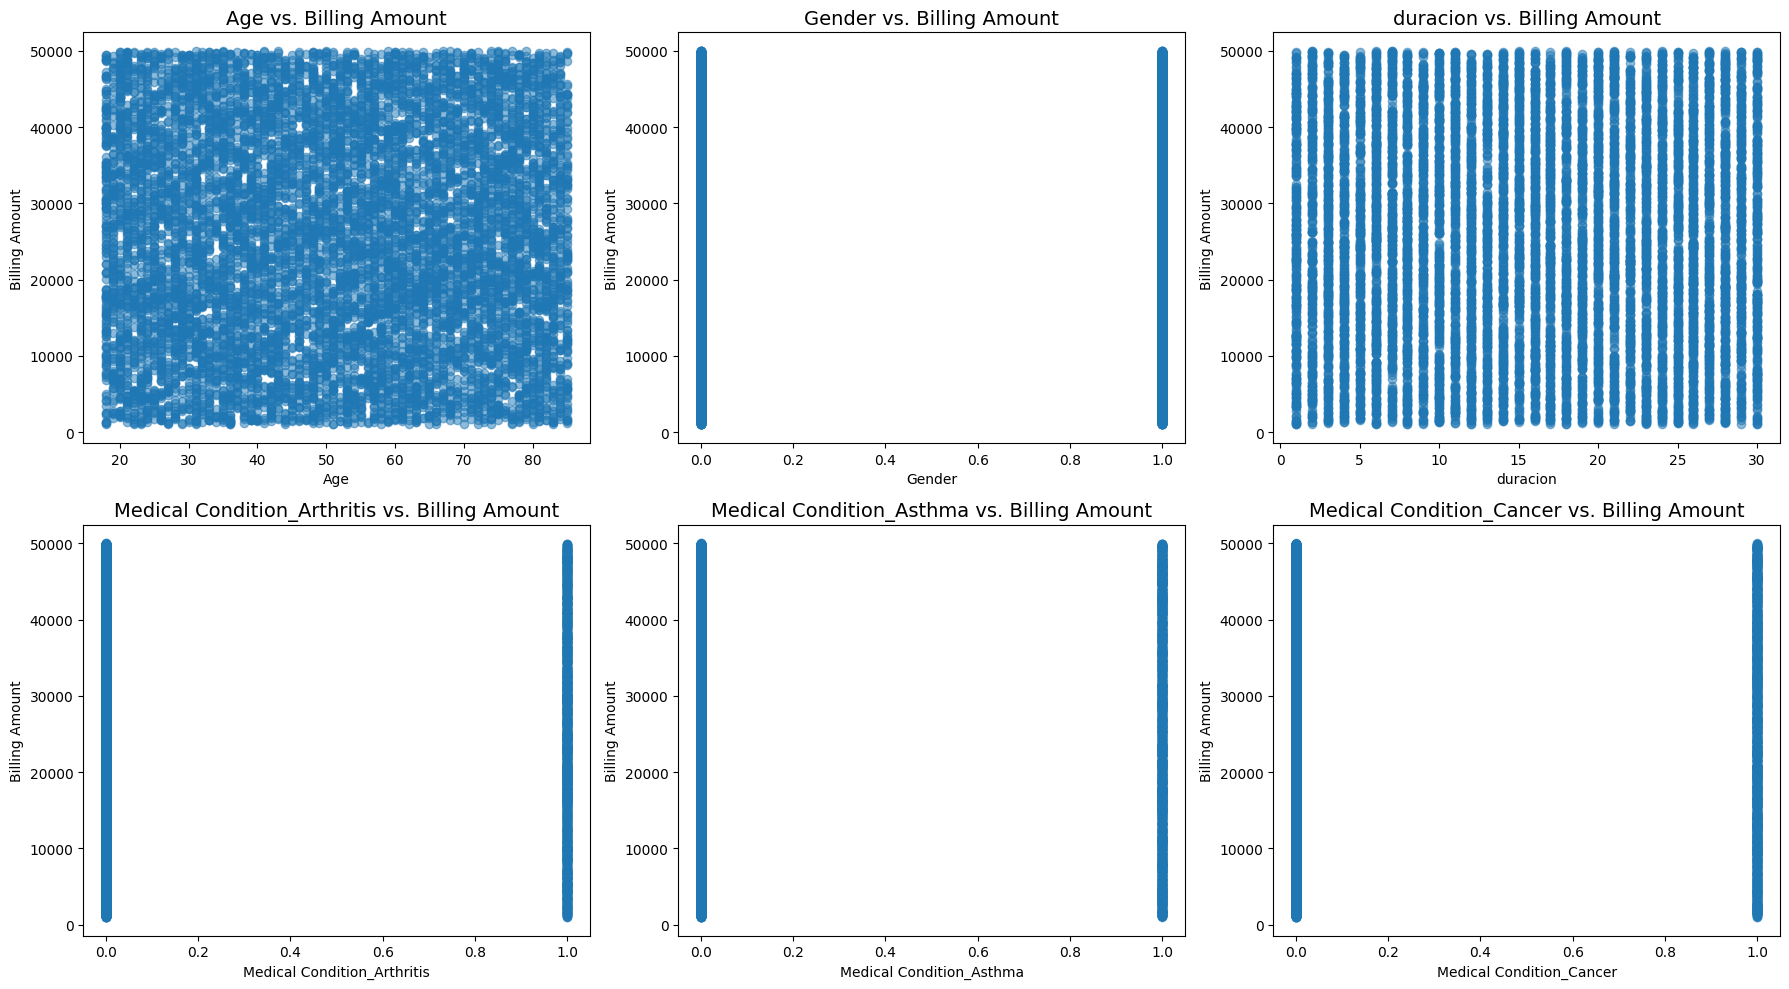

In [195]:
# Lista de columnas (ej: las más importantes del modelo)
l = list(cdf.index)   # asumiendo que cdf tiene tus coeficientes / features ordenadas

# Cuántas variables quieres graficar (ej: 6 primeras)
n = 6
cols_to_plot = l[:n]

# Definir el grid: 2 filas x 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # para iterar fácilmente

# Hacer scatter plot para cada columna contra "Billing Amount"
for i, col in enumerate(cols_to_plot):
    axes[i].scatter(df[col], df["Billing Amount"], alpha=0.5)
    axes[i].set_title(f"{col} vs. Billing Amount", fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Billing Amount")

plt.tight_layout()
plt.show()

**R cuadrado del ajuste del modelo**

In [196]:
print("Valor del R cuadrado de este ajuste:",round(metrics.r2_score(y_train,train_pred),3))

Valor del R cuadrado de este ajuste: 0.003


### Matrices de evaluación de predicción, estimación de error y regresión

**Predicción usando el modelo lm**

In [197]:
predictions = lm.predict(X_test)
print ("Tipo del objeto predicho :", type(predictions))
print ("Tamaño del objeto predicho:", predictions.shape)

Tipo del objeto predicho : <class 'numpy.ndarray'>
Tamaño del objeto predicho: (2000,)


**Diagrama de dispersión (Scatterplot) del precio previsto y el conjunto de prueba y para ver si los datos caen en una línea recta de 45 grados**

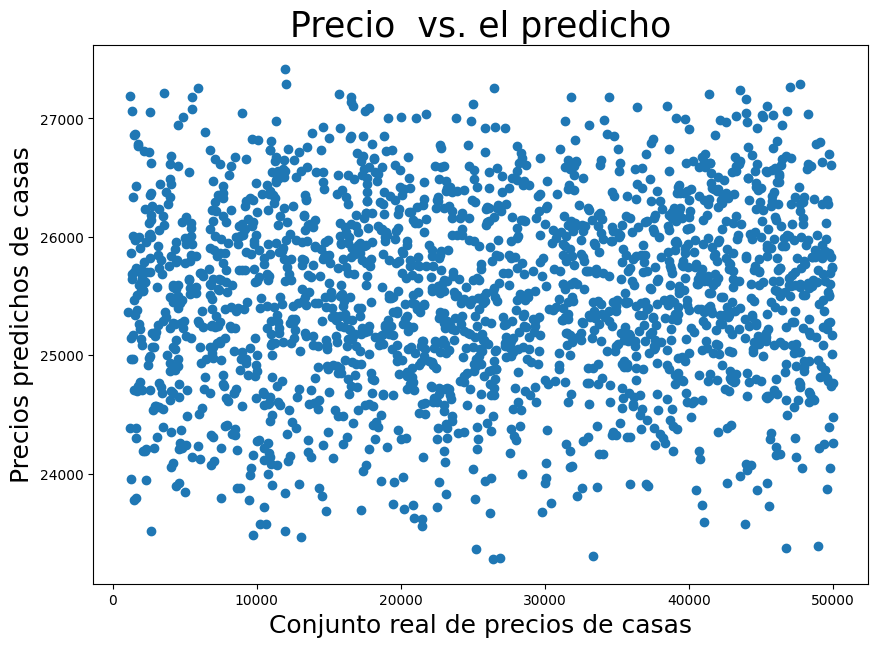

In [198]:
plt.figure(figsize=(10,7))
plt.title("Precio  vs. el predicho",fontsize=25)
plt.xlabel("Conjunto real de precios de casas",fontsize=18)
plt.ylabel("Precios predichos de casas", fontsize=18)
plt.scatter(x=y_test,y=predictions)

**Visualizamos el histograma de los residuos, es decir, errores predichos (se espera un patrón distribuido normalmente)**

C:\Users\LUIS ACEVEDO\AppData\Local\Temp\ipykernel_2940\1939217874.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([y_test-predictions])


<Axes: title={'center': 'Histograma de residuos para verificar la normalidad '}, xlabel='Residuos', ylabel='Densidad del kernel'>

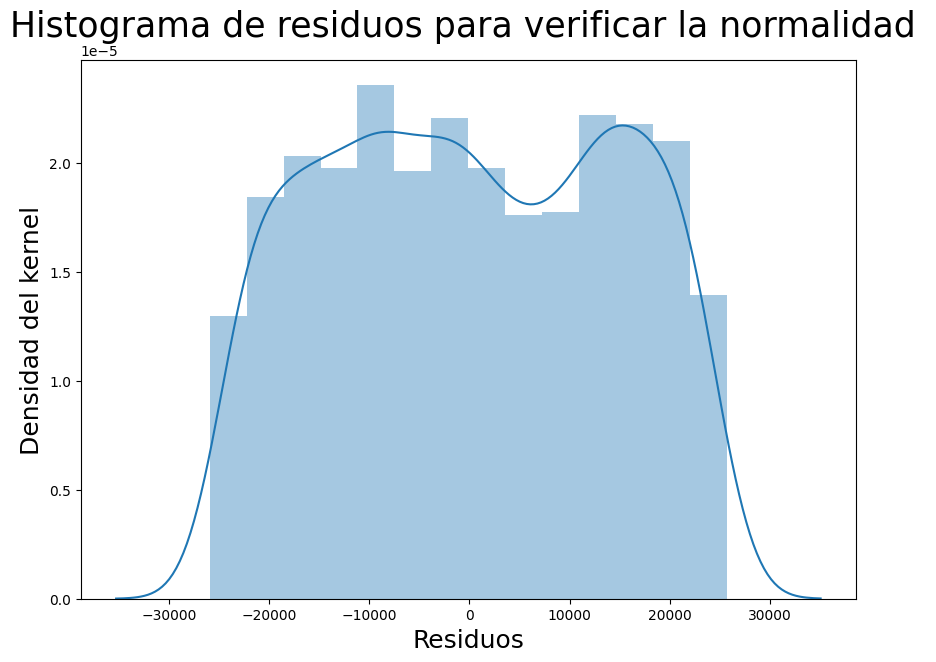

In [199]:
plt.figure(figsize=(10,7))
plt.title("Histograma de residuos para verificar la normalidad ",fontsize=25)
plt.xlabel("Residuos",fontsize=18)
plt.ylabel("Densidad del kernel", fontsize=18)
sns.distplot([y_test-predictions])

**Diagrama de dispersión de residuos y valores predichos (Homoscedasticidad)**


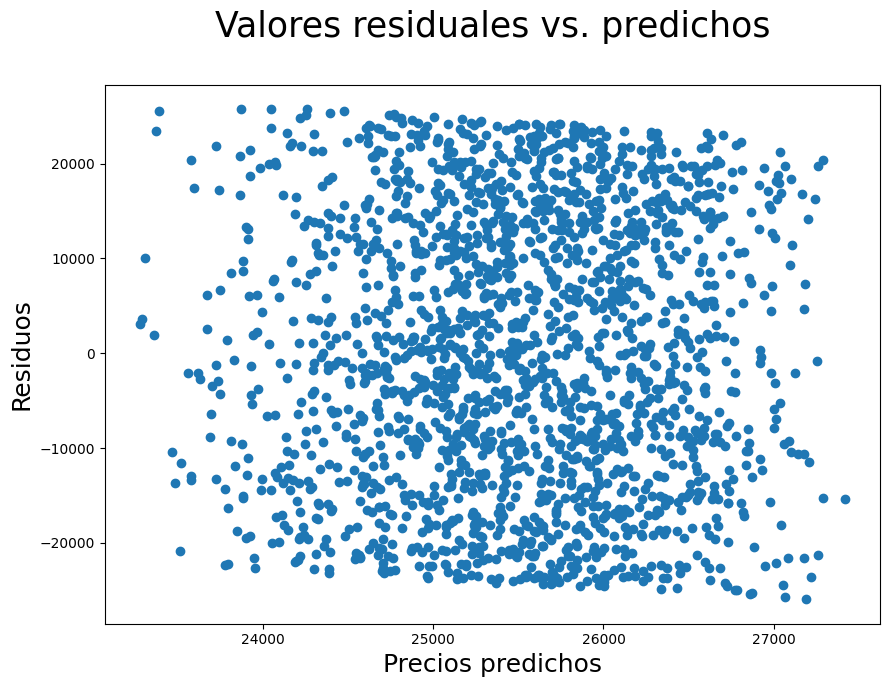

In [200]:
plt.figure(figsize=(10,7))
plt.title("Valores residuales vs. predichos\n",fontsize=25)
plt.xlabel("Precios predichos",fontsize=18)
plt.ylabel("Residuos", fontsize=18)
plt.scatter(x=predictions,y=y_test-predictions)

**Métricas de evaluación de la regresión**

In [201]:
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test,predictions))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test,predictions))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test,predictions)))

Mean absolute error (MAE): 12339.434680914279
Mean square error (MSE): 202729795.05355203
Root mean square error (RMSE): 14238.321356590883


**Valor R cuadrado**

In [203]:
print("Valor R-squared de las predicciones:",round(metrics.r2_score(y_test,predictions),3))

Valor R-squared de las predicciones: 0.004


EL valor final no pasa ni el 10% seria por que en los gráficos no visualizamos bien una recta, tambien se puede por falta de mas datos o detallar cosas más, para mejorar y elevar el r-squared.